<a href="https://colab.research.google.com/github/thebouabidi/ArtAura/blob/main/Syst%C3%A8mederecommandationFilms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
import zipfile
import io
import requests

url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

ratings = pd.read_csv(z.open('ml-latest-small/ratings.csv'))
movies = pd.read_csv(z.open('ml-latest-small/movies.csv'))


In [5]:
ratings.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
movies.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
ratings.describe()


,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


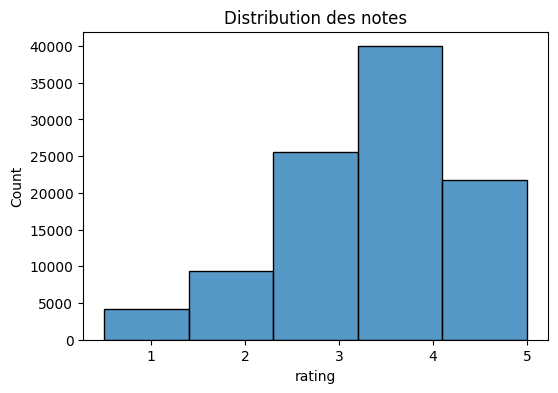

In [8]:
plt.figure(figsize=(6,4))
sns.histplot(ratings['rating'], bins=5)
plt.title("Distribution des notes")
plt.show()


In [9]:
ratings.isnull().sum()


,0
userId,0
movieId,0
rating,0
timestamp,0


In [10]:
ratings.duplicated().sum()


np.int64(0)

In [11]:
ratings = ratings.drop_duplicates()


In [12]:
data = pd.merge(ratings, movies, on='movieId')
data.head()


,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [13]:
user_counts = data['userId'].value_counts()
movie_counts = data['movieId'].value_counts()

data = data[
    data['userId'].isin(user_counts[user_counts >= 20].index) &
    data['movieId'].isin(movie_counts[movie_counts >= 20].index)
]


In [14]:
popular_movies = (
    data.groupby('title')['rating']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

popular_movies


,rating
title,
"Streetcar Named Desire, A (1951)",4.475000
"Shawshank Redemption, The (1994)",4.429022
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.333333
"Philadelphia Story, The (1940)",4.310345
In the Name of the Father (1993),4.300000
Lawrence of Arabia (1962),4.300000
Hoop Dreams (1994),4.293103
"Godfather, The (1972)",4.289062
Harold and Maude (1971),4.288462


In [15]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [16]:
user_movie_matrix = data.pivot_table(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)


In [17]:
user_similarity = cosine_similarity(user_movie_matrix)
user_similarity_df = pd.DataFrame(
    user_similarity,
    index=user_movie_matrix.index,
    columns=user_movie_matrix.index
)


In [18]:
def recommander_films_user_based(user_id, n=5):
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:6]

    weighted_ratings = user_movie_matrix.loc[similar_users.index].T.dot(similar_users)
    recommendation_scores = weighted_ratings / similar_users.sum()

    films_vus = user_movie_matrix.loc[user_id]
    recommendation_scores = recommendation_scores[films_vus == 0]

    top_films = recommendation_scores.sort_values(ascending=False).head(n)

    return movies[movies['movieId'].isin(top_films.index)]['title'].values


In [19]:
recommander_films_user_based(user_movie_matrix.index[0])


array(['Godfather, The (1972)', 'Escape from New York (1981)',
       'Aliens (1986)', 'Jaws (1975)', 'Hunt for Red October, The (1990)'],
      dtype=object)

In [20]:
R = user_movie_matrix.values
S = user_similarity

predicted = S.dot(R) / np.abs(S).sum(axis=1).reshape(-1, 1)

predicted


array([[1.81892117, 0.85156336, 0.42646323, ..., 0.19794491, 0.22441664,
        0.20766148],
       [1.38896866, 0.65426615, 0.16101642, ..., 0.42642338, 0.40309456,
        0.45711849],
       [1.75228482, 0.8793144 , 0.49952927, ..., 0.26280834, 0.33083677,
        0.26304803],
       ...,
       [1.80476118, 0.92188353, 0.39109334, ..., 0.22841532, 0.26538308,
        0.25355409],
       [1.68452822, 0.89270377, 0.37370719, ..., 0.11218269, 0.12528705,
        0.13095317],
       [1.75059985, 0.84551946, 0.28786509, ..., 0.35725269, 0.38756943,
        0.37592027]])

In [21]:
from sklearn.metrics import mean_squared_error
import numpy as np

mask = R > 0

rmse = np.sqrt(
    mean_squared_error(
        R[mask],
        predicted[mask]
    )
)

rmse


np.float64(2.9560691205803207)